In [1]:
import asyncio
import streamlit as st
from typing import TypedDict, List, Dict, Any
from streamlit.runtime.uploaded_file_manager import UploadedFile

from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda

from Agents.doc_parser import parse_documents_parallel
from Agents.validation import validate_data
from Agents.checklist import run_checklist


# --- Pipeline State Definition ---
class PipelineState(TypedDict, total=False):
    uploaded_files: List[UploadedFile]
    parsed_data: Dict[str, Any]
    checklist_result: Any
    validation_result: Any


# --- Router: only run validate_data if PO document is present ---
def should_run_validation(state: PipelineState) -> str:
    parsed = state.get("parsed_data", {})
    for doc in parsed.values():
        if doc.get("doc_type", "").upper() == "PO":
            return "validate"
    return "skip"


# --- Node: Parse uploaded documents ---

async def parse_documents_node(state: PipelineState) -> PipelineState:
    parsed = await parse_documents_parallel(state["uploaded_files"])
    return {"parsed_data": parsed}


# --- LangGraph builder ---
def build_graph():
    graph = StateGraph(PipelineState)

    graph.add_node("parse_documents", RunnableLambda(parse_documents_node))
    graph.add_node("checklist", RunnableLambda(run_checklist))
    graph.add_node("validate_data", RunnableLambda(validate_data))
    graph.add_node("skip", RunnableLambda(lambda state: {
        "parsed_data": state["parsed_data"]
    }))

    graph.set_entry_point("parse_documents")

    # Always run checklist
    graph.add_edge("parse_documents", "checklist")

    # Conditionally run validation
    graph.add_conditional_edges("parse_documents", should_run_validation, {
        "validate": "validate_data",
        "skip": "skip"
    })

    # Terminal edges
    graph.add_edge("checklist", END)
    graph.add_edge("validate_data", END)
    graph.add_edge("skip", END)

    return graph.compile()


# --- Streamlit UI ---
if __name__ == "__main__":
    st.set_page_config(page_title="📄 Document Pipeline", layout="centered")
    st.title("📄 Document Parser with Checklist + Conditional Validation")

    uploaded_files = st.file_uploader(
        "Upload one or more PDF files",
        type="pdf",
        accept_multiple_files=True
    )

    if uploaded_files:
        with st.spinner("Running document pipeline..."):
            pipeline = build_graph()
            initial_state: PipelineState = {"uploaded_files": uploaded_files}
            final_output = asyncio.run(pipeline.ainvoke(initial_state))

        st.subheader("✅ Final Output")
        st.json({
            "parsed_data": final_output.get("parsed_data"),
            "validation_result": final_output.get("validation_result"),
            "checklist_result": final_output.get("checklist_result")
        })


2025-05-10 01:08:57.128 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-10 01:08:57.129 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-10 01:08:57.213 
  command:

    streamlit run /Users/belalelshenety/Documents/GitHub/DxHub/university-buyerreview/.venv/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-05-10 01:08:57.214 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-10 01:08:57.214 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-10 01:08:57.214 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-10 01:08:57.214 Thread 'MainThread': mis

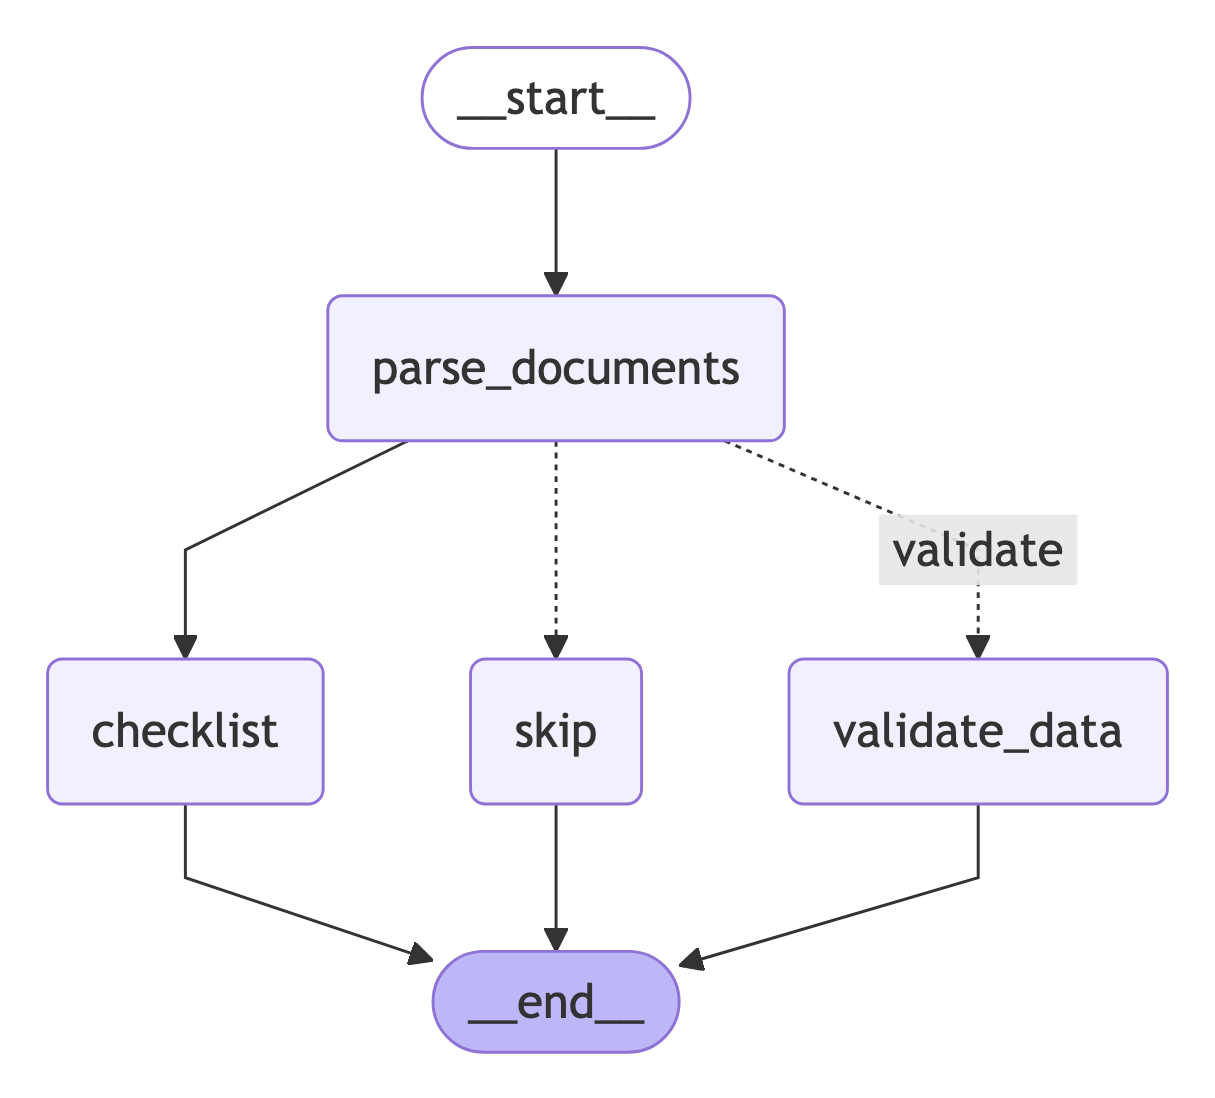

In [10]:
import nest_asyncio
nest_asyncio.apply()
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

app = build_graph()

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.PYPPETEER
        )
    )
)
